This notebook is going to clean up the sympy work to get the voltage and current equations.

Once this is cleaned up, I can modify to correctly handle the three phase quantities.

- TODO: see how to confirm the voltage constant of crystalyte
    - get no load speed 
    - get oscope constant and correct for poles 
    - get datasheet constant
- TODO: how do I handle the line-line line-neutral transformations correctly?
    - reread section of Mevey on line-line vs line-neutral stuff
- TODO: handle case where peak battery or phase current can't be reached

Notes

- I_c V_c looks like about I_b V_b / sqrt(3) in the VESC data

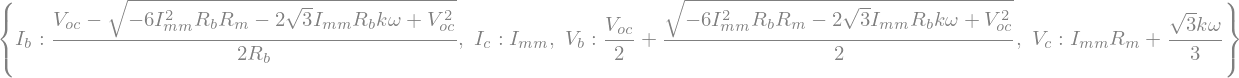

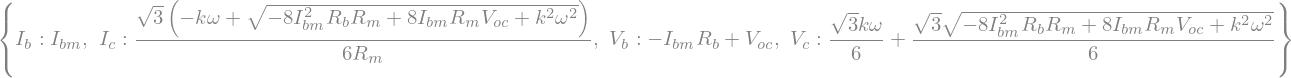

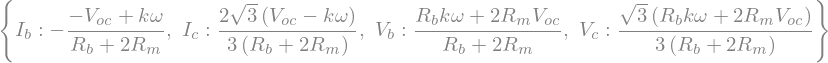

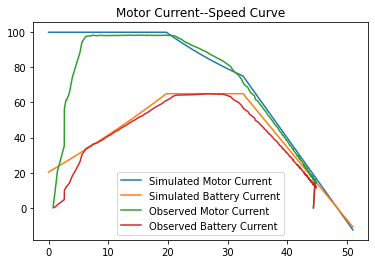

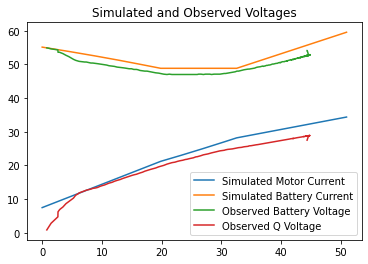

In [13]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../ev_data')
import ev as evd
import ev_model as evm
import sympy
import numpy as np
import matplotlib.pyplot as plt

# perform symbolic equation solving
Ib, Ic, Vb, Vc, Rm, k, omega, Rb, Voc, Imm, Ibm, torque = evm.define_variables()
#power_eq, controller_loop, battery_loop, regime_1_eq, regime_2_eq, regime_3_eq = evm.define_equations_dc(Ib, Ic, Vb, Vc, Rm, k, omega, Rb, Voc, Imm, Ibm, torque)
power_eq, controller_loop, battery_loop, regime_1_eq, regime_2_eq, regime_3_eq = evm.define_equations_3p(Ib, Ic, Vb, Vc, Rm, k, omega, Rb, Voc, Imm, Ibm, torque)
phase_limit, battery_limit, duty_limit = evm.solve_equations(power_eq, controller_loop, battery_loop, regime_1_eq, regime_2_eq, regime_3_eq,
                                                             Ib, Ic, Vb, Vc, Rm, k, omega, Rb, Voc, Imm, Ibm, torque)
evm.display_equations(phase_limit, battery_limit, duty_limit)

# calculate values based on closed-form equations
ev_system = {Rb: 0.141, Voc:58, Imm: 100, Ibm:65, Rm: 0.075, k:1.2}
omega_1_2, omega_2_3, omega_3 = evm.calculate_crossover_frequencies(phase_limit, battery_limit, duty_limit, ev_system,  
                                                                    Ib, Ic, Vb, Vc, Rm, k, omega, Rb, Voc, Imm, Ibm, torque)
omega_values, Ib_values, Ic_values = evm.generate_currents(ev_system, phase_limit, battery_limit, duty_limit, 
                                                           Ib, Ic, Vb, Vc, Rm, k, omega, Rb, Voc, Imm, Ibm, torque)    
omega_values, Vb_values, Vc_values = evm.generate_voltages(ev_system, phase_limit, battery_limit, duty_limit, 
                                                           Ib, Ic, Vb, Vc, Rm, k, omega, Rb, Voc, Imm, Ibm, torque)    

plt.plot(omega_values, Ic_values, label='Simulated Motor Current')
plt.plot(omega_values, Ib_values, label='Simulated Battery Current')    

# overlay observed data
data = evd.vesc_csv_to_df('data.csv')
data = evd.pull_throttle_region(data)
data['rad_per_sec'] = evd.rpm_to_radpsec(data, pole_pairs=23)
plt.plot(data['rad_per_sec'], data['current_motor'], label='Observed Motor Current')
plt.plot(data['rad_per_sec'], data['current_in'], label='Observed Battery Current')
plt.legend()
plt.title('Motor Current--Speed Curve')
plt.show()

plt.plot(omega_values, Vc_values, label='Simulated Motor Current')
plt.plot(omega_values, Vb_values, label='Simulated Battery Current')    
plt.title('Simulated and Observed Voltages')

# overlay observed data
data = evd.vesc_csv_to_df('data.csv')
data = evd.pull_throttle_region(data)
data['rad_per_sec'] = evd.rpm_to_radpsec(data, pole_pairs=23)
plt.plot(data['rad_per_sec'], data['input_voltage'], label='Observed Battery Voltage')
plt.plot(data['rad_per_sec'], data['q_axis_voltage'], label='Observed Q Voltage')
plt.legend()
plt.show()